<a href="https://colab.research.google.com/github/snv-ds/NLP_course/blob/master/week4/seminar_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this lesson we will explore how to solve text generation task, explore new but practically old theme of tokenization and look and sampling techniques more thorougly

Our goals is to:


*   explore tokenization and modern libraries for it
*   train statistical language model
*   learn how to train text generation model
*   look how we can affect on text generation



# PART 1

You know that tokenization is a simple operation to split text into the simplest components. They can be either separate words, symbols or something more.<br>
There is a specially designed library for tokenization - `tokenizers`. It aggregates many realizations of different tokenization approaches. Futher we will explore some of them.

In [ ]:
!pip install tokenizers > /dev/null
!pip install datasets > /dev/null

Let's load some data for train

In [ ]:
import datasets

dataset = datasets.load_dataset('imdb')

### Byte Pair Encoding



BPE relies on a pre-tokenizer that splits the training data into words.<br>
After pre-tokenization, a set of unique words has been created and the frequency of each word it occurred in the training data has been determined. Next, BPE creates a base vocabulary consisting of all symbols that occur in the set of unique words and learns merge rules to form a new symbol from two symbols of the base vocabulary. It does so until the vocabulary has attained the desired vocabulary size. Note that the desired vocabulary size is a hyperparameter to define before training the tokenizer.


Usage of this metod looks like this

In [ ]:
from tokenizers import Tokenizer, trainers
from tokenizers.models import BPE

tokenizer = Tokenizer(BPE())
trainer = trainers.BpeTrainer(
    vocab_size=30000,
    special_tokens=["<PAD>", "<BOS>", "<EOS>"],
)

You can train tokenizer from any iterable objects, file or even gzip files.

Look at the data

In [ ]:
dataset['train']['text']

In [ ]:
tokenizer.train_from_iterator(dataset['train']['text'], trainer=trainer)

In [ ]:
tokenizer.get_vocab()

In [ ]:
tokenizer.encode("A sequence to tokenize").tokens

## Unigram

Unigram is a subword tokenization algorithm introduced in  [Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (Kudo, 2018)](https://arxiv.org/pdf/1804.10959.pdf). In contrast to BPE or WordPiece, Unigram initializes its base vocabulary to a large number of symbols and progressively trims down each symbol to obtain a smaller vocabulary. The base vocabulary could for instance correspond to all pre-tokenized words and the most common substrings. Unigram is not used directly for any of the models in the transformers, but it’s used in conjunction with [SentencePiece](https://huggingface.co/transformers/tokenizer_summary.html#sentencepiece).

At each training step, the Unigram algorithm defines a loss (often defined as the log-likelihood) over the training data given the current vocabulary and a unigram language model. Then, for each symbol in the vocabulary, the algorithm computes how much the overall loss would increase if the symbol was to be removed from the vocabulary. Unigram then removes p (with p usually being 10% or 20%) percent of the symbols whose loss increase is the lowest, i.e. those symbols that least affect the overall loss over the training data. This process is repeated until the vocabulary has reached the desired size. The Unigram algorithm always keeps the base characters so that any word can be tokenized.

Because Unigram is not based on merge rules (in contrast to BPE and WordPiece), the algorithm has several ways of tokenizing new text after training. 

Simple usage

In [ ]:
from tokenizers import models, normalizers, pre_tokenizers, decoders

tokenizer = Tokenizer(models.Unigram())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
tokenizer.decoders = decoders.ByteLevel()

trainer = trainers.UnigramTrainer(
    vocab_size=20000,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
    special_tokens=["<PAD>", "<BOS>", "<EOS>"],
)

tokenizer.train_from_iterator(dataset['train']['text'], trainer=trainer)

In [ ]:
tokenizer.encode("A sequence to tokenize").tokens

### Task 1 

You can train tokenizer yeilding batches to trainer. Write function that take text data from dataset variable as input and yeilds some portion of data. Each batch must be the same size and takes samples from dataset. Go trough all samples of dataset.

In [ ]:
# YOUR CODE HERE
def batch_iterator(batch_size=1000):
  pass

train your tokenizer using function above

In [ ]:
len(dataset['train'])

In [ ]:
tokenizer.train_from_iterator(batch_iterator(), trainer=trainer, length=len(dataset))

In [ ]:
assert len(tokenizer.encode("A sequence to tokenize").tokens) == 6
assert len(tokenizer.encode("A yet anoter sequence to tokenize").tokens) == 10

# PART 2

In [ ]:
import tqdm

Here we will make simple statistical language model based on our little corpora.

### Task 2

Let's combine together all samples from train dataset in a single list

In [ ]:
# YOUR CODE HERE
all_texts = list()

In [ ]:
assert len(all_texts) == 25000
assert len(all_texts[5]) == 1017
assert all_texts[23].split()[7] == 'career'

To build statistical model we will use simple python dictionaries. 

In [ ]:
import sys
from nltk import bigrams, trigrams
from collections import Counter, defaultdict


model = defaultdict(lambda: defaultdict(lambda: 0))

In [ ]:
# counting  
for sentence in tqdm.notebook.tqdm(all_texts):
    for w1, w2 in bigrams(sentence.split(), pad_right=True, pad_left=True):
        model[(w1)][w2] += 1
 
# Convert quantities to probabilities
for w1 in model:
    total_count = float(sum(model[w1].values()))
    for w2 in model[w1]:
        model[w1][w2] /= total_count

### Task 3

Make model based on trigrams. As key of dictinary we get context and as value we get another dictionary. Then for each word for given context we need to count probability.

##### help

In [ ]:
# 1. create dictionary
# 2. iterate through all trigrams in all_texts and count occurence of each last word with first 2 word as context
# 3. sum all possible words for given context and get probabilities for occurence of each word with corresponding context

##### Continue work


In [ ]:
# YOUR CODE HERE

model = defaultdict(lambda: defaultdict(lambda: 0))

In [ ]:
assert max(model[('one', 'of')], key=lambda x: model[('one', 'of')][x])
assert sum(sorted(model[('A', 'classic')].values())[:-2]) < 0.87

Let's generate some text. You can set your own beginning words. Be accurate, your model can hung up in infinite loop if you set words, that don't exsist in your model

In [ ]:
import random

# Beginning words for generation
text = ['This', 'film']
sentence_finished = False
 
while not sentence_finished:
  # chose random float number for boarder
  r = random.random()
  accumulator = .0

  for word in model[tuple(text[-2:])].keys():
      accumulator += model[tuple(text[-2:])][word]
      # we select only words that have a probability higher than the previously set boarder
      if accumulator >= r:
          text.append(word)
          break

  if text[-2:] == [None, None]:
      sentence_finished = True
 
print (' '.join([t for t in text if t]))

If you want, you can make your model more applicapable by setting another values for unigram. You will use them to prevent infinite loop at the start of generation.

# Part 3

In this part we will train char level neural language model to generate Shakespeare-like sonnets. It is rather common task, but you can apply this model for any dataset.

In [ ]:
!wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt

In [ ]:
import time
import random
import string
import re

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

torch.backends.cudnn.deterministic = True

In [ ]:
with open('sonnets.txt', 'r') as iofile:
  text = iofile.readlines()

trim some text that have unuseful information

In [ ]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]

### Task 4

Join all the strings into one. Put result into variable `text`.

In [ ]:
# YOUR CODE HERE

# text = 

For this task we don't have to use GPU because out training will not take so much time

In [ ]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device('cpu')

TEXT_LENGTH = len(text)
TEXT_PORTION_SIZE = 200

NUM_ITER = 5000
LEARNING_RATE = 0.005
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
NUM_HIDDEN_LAYERS = 1

print('Device:', DEVICE)

### Task 5

Divide the text into smaller portions. Write function that return random chunk of our text. Chunk size must be `TEXT_PORTION_SIZE`

##### help

In [ ]:
# 1. Init start index for portion of text. You can randomly choose index between 0 and TEXT_LENGTH - TEXT_PORTION_SIZE
# 2. define end index
# 3. return chunk with corresponding slice

##### Continue work


In [ ]:
# YOUR CODE HERE
random.seed(RANDOM_SEED)

def random_portion(textfile):
    start_index = None
    end_index = None
    return textfile[start_index:end_index]

Define function to translate some text into tensor with integers, that correspond to index of symbols

In [ ]:
def char_to_tensor(text):
    lst = [string.printable.index(c) for c in text]
    tensor = torch.tensor(lst).long()
    return tensor

print(char_to_tensor('abcDEF'))

### Task 6

Put it together to make a function that draws random batches for training. You need to return two batches. First - random chunk of data. Second - chunk from previous step with offset by one character futher. (We need to predict next character).<br>
 Do not forget to receive tensors with integers!

In [ ]:
# YOUR CODE HERE

def draw_random_sample(textfile):    
    pass

In [ ]:
inp_1, out_1 = draw_random_sample(text)

assert inp_1[5] == out_1[4]
assert len(inp_1) == TEXT_PORTION_SIZE
assert len(out_1) == TEXT_PORTION_SIZE

Now we can define our char RNN model

### Task 7

Init appropriate layers in our char rnn model. We will use LSTM as rnn block.

In [ ]:
# YOUR CODE HERE
class RNN(torch.nn.Module):
    def __init__(self, input_size, embed_size,
                 hidden_size, output_size, num_layers):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = # FILL YOUR CODE
        self.rnn = # FILL YOUR CODE
        self.fc = # FILL YOUR CODE
    
    def forward(self, features, hidden_and_cell_state):
        features = features.view(1, -1)
        embedded = self.embed(features)
        
        output, hidden_and_cell_state = self.rnn(embedded, hidden_and_cell_state)
        
        output.squeeze_(0)
        output = self.fc(output)
        return output, hidden_and_cell_state
      
    def init_zero_state(self):
        init_hidden = torch.zeros(self.num_layers, 1, self.hidden_size).to(DEVICE)
        init_cell = torch.zeros(self.num_layers, 1, self.hidden_size).to(DEVICE)
        return (init_hidden, init_cell)

In [ ]:
torch.manual_seed(RANDOM_SEED) # we use this for reproducibility

model = RNN(len(string.printable), EMBEDDING_DIM, HIDDEN_DIM,
            len(string.printable), NUM_HIDDEN_LAYERS)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = F.cross_entropy

Check that loss calculate correctly

In [ ]:
inputs, targets = draw_random_sample(text)
outputs, _ = model(inputs[0], model.init_zero_state()) # we pass it to the model input sequence and some hidden state
criterion(outputs, targets[0].view(1)) # measure quality only on first predictable symbol

In [ ]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):

  hidden_and_cell_state = model.init_zero_state()
  prime_input = char_to_tensor(prime_str)
  predicted = prime_str

  # Use priming string to "build up" hidden state
  for p in range(len(prime_str) - 1):
    _, hidden_and_cell_state = model(prime_input[p].to(DEVICE), hidden_and_cell_state)
    inp = prime_input[-1]
    
    for p in range(predict_len):
      output, hidden_and_cell_state = model(inp.to(DEVICE), hidden_and_cell_state)
        
      # Sample from the network as a multinomial distribution
      output_dist = output.data.view(-1).div(temperature).exp()
      top_i = torch.multinomial(output_dist, 1)[0]
        
      # Add predicted character to string and use as next input
      predicted_char = string.printable[top_i]
      predicted += predicted_char
      inp = char_to_tensor(predicted_char)

  return predicted

### Task 8

Complete training loop

In [ ]:
start_time = time.time()

loss_list = []

for iteration in range(NUM_ITER):

    hidden_and_cell_state = model.init_zero_state()
    # Fill optimizer zeroing
    
    loss = 0.
    inputs, targets = draw_random_sample(text)
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    for c in range(TEXT_PORTION_SIZE):
        outputs, hidden_and_cell_state = # get prediction from model
        loss += # count loss

    loss /= TEXT_PORTION_SIZE
    # run backward pass
    
    # update model parameters
    

    ### LOGGING
    with torch.no_grad():
        if iteration % 200 == 0:
            print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
            print(f'Iteration {iteration} | Loss {loss.item():.2f}\n\n')
            print(evaluate(model, 'Th', 200), '\n')
            print(50*'=')
            
            loss_list.append(loss.item())
            plt.clf()
            plt.plot(range(len(loss_list)), loss_list)
            plt.ylabel('Loss')
            plt.xlabel('Iteration x 1000')
            
plt.clf()
plt.ylabel('Loss')
plt.xlabel('Iteration x 1000')
plt.plot(range(len(loss_list)), loss_list)
plt.show()

### Task 9

run evaluation with different temperature values `[0.2, 0.5, 0.75, 0.9, 1, 2, 4]` but with common beggining phrase. Print each evaluation in cycle.

In [ ]:
# YOU CODE HERE

In [ ]:
for T in [0.2, 0.5, 0.75, 0.9, 1, 2, 4]:
  print(T)
  print(evaluate(model, 'Th', 200, T), '\n')

### Task 10

Apply top-k sampling to evaluation function.

As a reminder

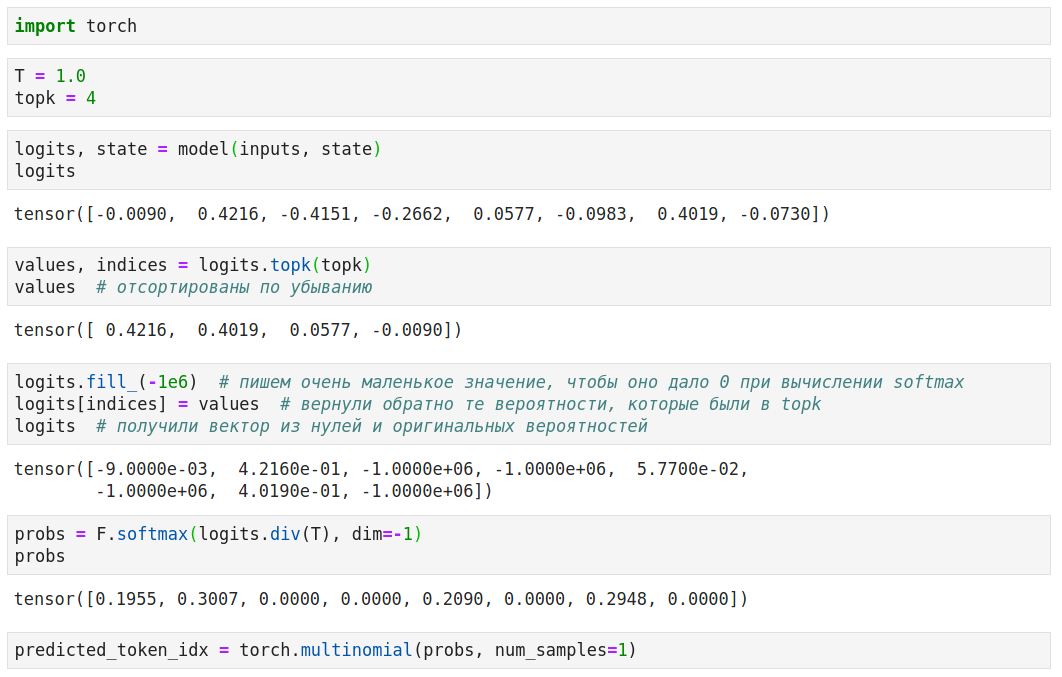

In [ ]:
# YOUR CODE HERE
def evaluate_top_k(model, prime_str='A', predict_len=100, temperature=0.8, top_k=5):

  hidden_and_cell_state = model.init_zero_state()
  prime_input = char_to_tensor(prime_str)
  predicted = prime_str

  # Use priming string to "build up" hidden state
  for p in range(len(prime_str) - 1):
    _, hidden_and_cell_state = model(prime_input[p].to(DEVICE), hidden_and_cell_state)
    inp = prime_input[-1]
    
    for p in range(predict_len):
      output, hidden_and_cell_state = model(inp.to(DEVICE), hidden_and_cell_state)

      # HERE YOU CAN ADD YOUR TOP_K SAMPLING
              
      # Sample from the network as a multinomial distribution
      output_dist = output.data.view(-1).div(temperature).exp()
      top_i = torch.multinomial(output_dist, 1)[0]
        
      # Add predicted character to string and use as next input
      predicted_char = string.printable[top_i]
      predicted += predicted_char
      inp = char_to_tensor(predicted_char)

  return predicted

In [ ]:
print(evaluate_top_k(model, 'Th', 200), '\n')

Futher steps to approve model:
- make your network bidirectional or try greater number of layers
- try ensemble of two models, trained separetly with different parameters
- try another sampling methods